# Система оценки риска виновности в ДТП

Вы — специалист по Data Scienсe в каршеринговой компании. Вам поступил заказ: нужно создать систему, которая могла бы оценить риск виновности в ДТП по выбранному маршруту движения. Под риском понимается вероятность оказаться виновным в ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

## Подключитесь к базе. Загрузите таблицы sql

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, plot_confusion_matrix, roc_auc_score, roc_curve 
from scipy.stats import loguniform
import copy
import warnings


warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
plt.rcParams["figure.figsize"] = (16,8)

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных, 
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

### Таблицы в базе данных

In [3]:
query = '''
SELECT table_name FROM information_schema.tables
WHERE table_schema NOT IN ('information_schema','pg_catalog');
'''

db_structure = pd.read_sql_query(query, con=engine) 
db_structure

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


Таблицы соответствуют описанию проекта

Теперь проверим наличие данных в каждой таблице по отдельности 

Количество записей каждой таблицы превышает 1млн, в связи с чем подгрузка всех данных происходит довольно медленно. Для ускорения загрузки ограничил количество получаемых записей значением 100 000

### Case_ids

In [4]:
query = '''
SELECT * FROM case_ids
LiMIT 100000
'''

case_ids = pd.read_sql_query(query, con=engine) 
case_ids

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
...,...,...
99995,4191845,2021
99996,4191846,2021
99997,4191847,2021
99998,4191848,2021


### Vehicles

In [5]:
query = '''
SELECT * FROM vehicles
LiMIT 100000
'''

vehicles = pd.read_sql_query(query, con=engine) 
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0
...,...,...,...,...,...,...
99995,1353590,5481590,2,sedan,auto,7.0
99996,1353596,5481593,2,sedan,auto,12.0
99997,1353608,5481601,1,sedan,auto,2.0
99998,1353606,5481598,1,sedan,None,3.0


### Collisions

In [6]:
query = '''
SELECT * FROM collisions
LiMIT 100000
'''

collisions = pd.read_sql_query(query, con=engine) 
collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,4468179,3605,san bernardino,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-10-31,12:18:00
99996,4468182,3607,san bernardino,450.0,west,0.0,clear,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,none,2009-11-06,19:20:00
99997,4468186,3607,san bernardino,1060.0,east,0.0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-11-10,15:35:00
99998,4468192,1953,los angeles,200.0,west,0.0,clear,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-10-06,16:40:00


### Parties

In [7]:
query = '''
SELECT * FROM parties
limit 100000
'''

parties = pd.read_sql_query(query, con=engine) 
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
...,...,...,...,...,...,...,...,...,...
99995,825513,4559178,1,car,0,51.0,had not been drinking,None,0.0
99996,825514,4559178,2,car,1,39.0,had not been drinking,None,0.0
99997,825523,4559182,2,road bumper,0,NaN,not applicable,not applicable,NaN
99998,825524,4559182,3,road bumper,0,NaN,not applicable,not applicable,NaN


### Вывод

В каждой таблице есть данные, структура таблиц полностью соответствует описанию. Общим ключом для связи всех таблиц служит **case_id**

##  Проведите статистический анализ факторов ДТП

### Динамика количества аварий

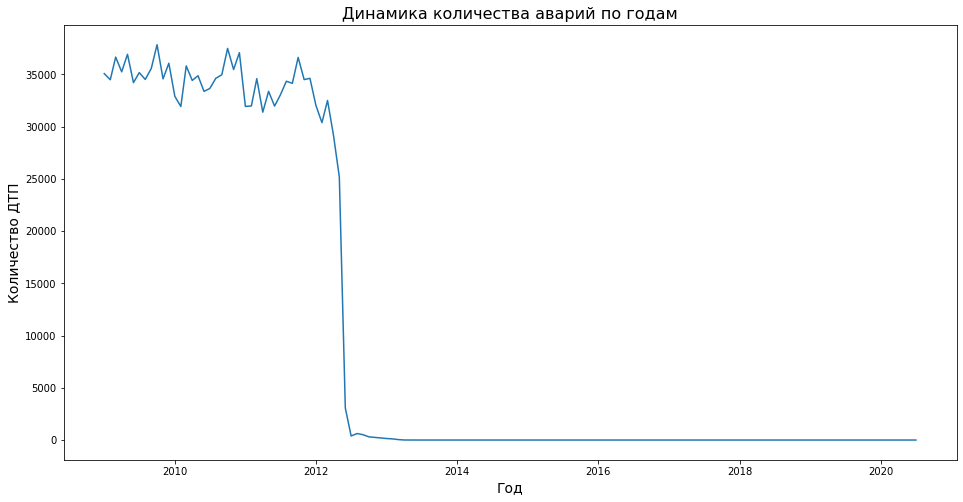

In [8]:
query = '''
SELECT DATE_TRUNC('month',collision_date)::date as month, count(*) FROM collisions
GROUP BY DATE_TRUNC('month',collision_date)::date
'''

accident_per_mnth = pd.read_sql_query(query, con=engine) 
accident_per_mnth['month'] = pd.to_datetime(accident_per_mnth['month'])


plt.plot("month", "count", data=accident_per_mnth)
plt.xlabel('Год', fontsize = 14)
plt.ylabel('Количество ДТП', fontsize = 14)
plt.title('Динамика количества аварий по годам', fontsize = 16)
plt.show()

По данному графику видно, что сведения о ДТП в основном собраны с 2009г по 2012г

### 2009 - 2012 годы

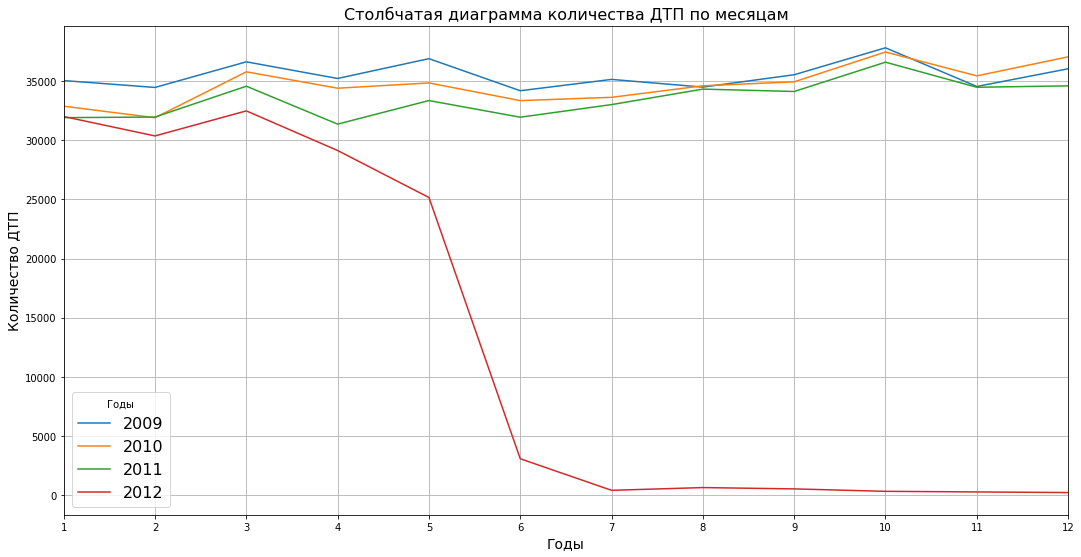

In [9]:
# Сгруппируем значения по месяцу и выведем эти значения с 2009 по 2013г
accident_per_mnth.query('month < 2013')\
.pivot_table(index=accident_per_mnth.query('month < 2013')['month'].dt.month, 
             columns=accident_per_mnth.query('month < 2013')['month'].dt.year, 
             values='count')\
.plot(figsize=(18,9))

plt.title(f'Столбчатая диаграмма количества ДТП по месяцам', fontsize=16)
plt.xlabel('Годы', fontsize=14)
plt.ylabel('Количество ДТП', fontsize=14)
plt.grid()
plt.legend(title='Годы', fontsize=16)
plt.xticks(np.arange(1, len(accident_per_mnth.query('month < 2013')['month'].dt.month.unique()) + 1, 1),
           rotation='horizontal')
plt.show()

### Вывод

По графику видно, что наибольшее количество ДТП по месяцам приходится на октябрь и декабрь и немного меньше на март. 

Начиная с мая 2012 года заметно резкое падение количества ДТП практически до 0. Похоже с тех пор сбор данных прекратился

### Аналитические задачи

* Проведите анализ трезвости участника в зависимости от времени происшествия (связать collisions и parties)
* Оценить как тип кузова влияет на стоимость страховки (связать parties и vehicles)
* Посчитайте количество происшествий в зависимости от погоды (таблица collisions)
* Посчитайте среднее количество участников происшествий (таблица collisions)
* Оцените при каком дорожном состоянии было максимальное количество ДТП (таблица collisions)
* Проведите анализ взаимосвязи между количеством ДТП и наличием телефона в автомобиле (таблица vehicles)


Порядок решения для задачи №1:
* Создайте SQL запрос (Объедините таблицы collisions и parties по общему ключу, выделите на основе времени происшествия категории: с 0 до 6 часов — ночь, с 6 до 12 часов — утро, с 12 до 18 часов — день, с 18 до 24 часов — вечер. После этого сгруппируйте значения по трезвости участника и времени суток и на основе сгруппированных значений выведите количество ДТП)  
* Постройте график
* Сделайте вывод

Порядок решения для задачи №2:
* Создайте SQL запрос (Объедините таблицы vehicles и parties по общему ключу, сгруппируйте значения по типу кузова и возьмите средние значения стоимости страховки)  
* Постройте график
* Сделайте вывод

## Отбор признаков

In [10]:
query = '''
SELECT * FROM collisions as col
INNER JOIN parties as part on col.case_id = part.case_id
INNER JOIN vehicles as vh on col.case_id = vh.case_id and part.party_number = vh.party_number
WHERE collision_damage != 'scratch' AND extract('year' from collision_date::date) = 2012 AND party_type = 'car'
'''

df = pd.read_sql_query(query, con=engine) 
df

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,...,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,5449062,0708,contra costa,21.0,east,0.0,clear,None,small damage,2,...,54.0,had not been drinking,None,0.0,1320506,5449062,2,sedan,manual,10.0
1,5455644,4806,solano,350.0,south,0.0,cloudy,ramp,small damage,3,...,22.0,had not been drinking,None,0.0,1327255,5455644,3,sedan,manual,3.0
2,5455680,3001,orange,0.0,None,1.0,clear,None,small damage,3,...,59.0,had not been drinking,None,0.0,1327290,5455680,3,sedan,manual,NaN
3,5455686,3906,san joaquin,400.0,west,0.0,fog,highway,small damage,1,...,30.0,had not been drinking,None,0.0,1327306,5455686,1,sedan,manual,3.0
4,5455744,1908,los angeles,500.0,east,0.0,clear,highway,small damage,2,...,20.0,had not been drinking,None,0.0,1327383,5455744,1,sedan,manual,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,5541557,3315,riverside,800.0,south,0.0,raining,ramp,middle damage,1,...,16.0,had not been drinking,None,0.0,1413124,5541557,1,coupe,manual,2.0
56244,5541776,1964,los angeles,1500.0,south,0.0,cloudy,highway,severe damage,3,...,40.0,had not been drinking,None,0.0,1413298,5541776,1,coupe,manual,6.0
56245,5541834,3045,orange,331.0,south,0.0,clear,None,middle damage,1,...,21.0,"had been drinking, under influence",None,0.0,1413363,5541834,1,coupe,manual,3.0
56246,5542149,5400,tulare,1600.0,north,0.0,clear,highway,fatal,1,...,24.0,"had been drinking, not under influence",None,0.0,1413809,5542149,1,coupe,manual,3.0


In [11]:
# Признаки

columms =[
          'party_sobriety', # Уровень трезвости виновника (точно может влиять) 
    
          'party_drug_physical', # Состояние участника: физическое или с учётом принятых лекарств 
                                # (состояние тоже может влиять на виновность в ДТП) 
    
          'cellphone_in_use', # Наличие телефона в автомобиле (по идее наличие возможности разговаривать 
                             # по громкой связи должна уменьшать вероятность вины в происшествии)
    
          'vehicle_age', # Возраст машины (чем старше машина, тем выше вероятность неожиданной поломки 
                        # и как следствие возникновения дтп по вине наблюдаемого водителя)
    
          'weather_1', # Погода (от погоды зависят условия видимости, состояние покрытия дороги, 
                      # следовательно этот фактор влияет на исследуемую переменную)
    
          'road_surface', # Покрытие дороги (тоже, думаю, влияет)
    
          'lighting', # Освещение (опять же сказывается на видимости и влияет на вероятность аварии)
    
          'county_location', # Названия географических районов, где произошло ДТП
                            # вероятность аварии в разных городах отличается. В густонаселенных городах
                            # автомобильный трафик выше чем в других, соответственно и вероятность дтп там выше
    
          'location_type', # Тип дороги (думаю тип дороги тоже должен влиять на вероятность аварии)
    
          'road_condition_1', # Дорожное состояние (этот признак должен быть тоже значимым)
    
          'insurance_premium', # Сумма страховки 
    
          'collision_date', # Дата происшествия (как мы уже выяснили выше, количество дтп изменяется по месяцам)
    
          'at_fault' # Целевой признак 
         ] 

### Исследовательский анализ

In [12]:
df = df[columms]
df

,party_sobriety,party_drug_physical,cellphone_in_use,vehicle_age,weather_1,road_surface,lighting,county_location,location_type,road_condition_1,insurance_premium,collision_date,at_fault
0,had not been drinking,None,0.0,10.0,clear,dry,dark with street lights,contra costa,None,normal,54.0,2012-01-15,0
1,had not been drinking,None,0.0,3.0,cloudy,dry,daylight,solano,ramp,normal,22.0,2012-01-02,1
2,had not been drinking,None,0.0,NaN,clear,dry,dark with street lights,orange,None,normal,59.0,2012-01-01,0
3,had not been drinking,None,0.0,3.0,fog,dry,dark with no street lights,san joaquin,highway,normal,30.0,2012-01-01,1
4,had not been drinking,None,0.0,3.0,clear,dry,daylight,los angeles,highway,normal,20.0,2012-01-08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56243,had not been drinking,None,0.0,2.0,raining,wet,daylight,riverside,ramp,normal,16.0,2012-03-17,1
56244,had not been drinking,None,0.0,6.0,cloudy,dry,dark with street lights,los angeles,highway,normal,40.0,2012-03-16,1
56245,"had been drinking, under influence",None,0.0,3.0,clear,dry,dark with street lights,orange,None,normal,21.0,2012-03-25,1
56246,"had been drinking, not under influence",None,0.0,3.0,clear,dry,dark with no street lights,tulare,highway,normal,24.0,2012-05-20,1


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 13 columns):
party_sobriety         55376 non-null object
party_drug_physical    2857 non-null object
cellphone_in_use       51777 non-null float64
vehicle_age            54554 non-null float64
weather_1              56080 non-null object
road_surface           55900 non-null object
lighting               56094 non-null object
county_location        56248 non-null object
location_type          25932 non-null object
road_condition_1       55999 non-null object
insurance_premium      55701 non-null float64
collision_date         56248 non-null object
at_fault               56248 non-null int64
dtypes: float64(3), int64(1), object(9)
memory usage: 5.6+ MB


#### Дубликаты

In [14]:
df.duplicated().sum()

586

In [15]:
df = df.drop_duplicates()

Практически все признаки категориальные. Уже сейчас видно, что есть признаки с большим количеством пропусков `party_drug_physical` и `location_type`

In [16]:
# Оценка количества пропусков в процентном соотношении

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

party_sobriety - 2.0%
party_drug_physical - 95.0%
cellphone_in_use - 8.0%
vehicle_age - 3.0%
weather_1 - 0.0%
road_surface - 1.0%
lighting - 0.0%
county_location - 0.0%
location_type - 54.0%
road_condition_1 - 0.0%
insurance_premium - 1.0%
collision_date - 0.0%
at_fault - 0.0%


95% пропусков в признаке состояния водителя и 54% в признаке типа дороги, слишком много, думаю стоит удалить эти признаки

In [17]:
# Проверим информативность признаков (выделим те, что имеют больше 95% повторяющихся значений)

num_rows = len(df.index)
low_information_cols = [] 

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

road_condition_1: 96.08710%
normal            53484
construction       1001
obstruction         248
NaN                 247
other               228
holes               222
loose material      128
reduced width        72
flooded              32
Name: road_condition_1, dtype: int64



Еще один признак на удаление - дорожное состояние. В 96% было нормальным. Этот признак является неинформативным

#### Удаление бесполезных признаков

In [18]:
df.drop(['road_condition_1', 'party_drug_physical', 'location_type'], axis= 1, inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55662 entries, 0 to 56247
Data columns (total 10 columns):
party_sobriety       54795 non-null object
cellphone_in_use     51212 non-null float64
vehicle_age          53969 non-null float64
weather_1            55494 non-null object
road_surface         55314 non-null object
lighting             55508 non-null object
county_location      55662 non-null object
insurance_premium    55119 non-null float64
collision_date       55662 non-null object
at_fault             55662 non-null int64
dtypes: float64(3), int64(1), object(6)
memory usage: 4.7+ MB


In [20]:
df.describe(include='all')

,party_sobriety,cellphone_in_use,vehicle_age,weather_1,road_surface,lighting,county_location,insurance_premium,collision_date,at_fault
count,54795,51212.000000,53969.000000,55494,55314,55508,55662,55119.000000,55662,55662.000000
unique,6,NaN,NaN,7,4,5,58,NaN,366,NaN
top,had not been drinking,NaN,NaN,clear,dry,daylight,los angeles,NaN,2012-03-17,NaN
freq,48035,NaN,NaN,44558,49683,37602,15831,NaN,566,NaN
mean,NaN,0.020562,4.863866,NaN,NaN,NaN,NaN,37.680074,NaN,0.504958
std,NaN,0.141913,3.241516,NaN,NaN,NaN,NaN,16.339192,NaN,0.499980
min,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000
25%,NaN,0.000000,3.000000,NaN,NaN,NaN,NaN,24.000000,NaN,0.000000
50%,NaN,0.000000,4.000000,NaN,NaN,NaN,NaN,34.000000,NaN,1.000000
75%,NaN,0.000000,7.000000,NaN,NaN,NaN,NaN,49.000000,NaN,1.000000


In [21]:
# Оценка количества пропусков в процентном соотношении

for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

party_sobriety - 2.0%
cellphone_in_use - 8.0%
vehicle_age - 3.0%
weather_1 - 0.0%
road_surface - 1.0%
lighting - 0.0%
county_location - 0.0%
insurance_premium - 1.0%
collision_date - 0.0%
at_fault - 0.0%


В оставшихся признаках количество пропусков не превышает 10%, заменим пропуски модой

In [22]:
# Заполнение пропусков наиболее часто встречающимися значениями

imputer_1 = SimpleImputer(strategy='most_frequent')
imputer_2 = SimpleImputer(missing_values=None, strategy='most_frequent')
cols = df.columns

df[cols] = imputer_1.fit_transform(df[cols])
df[cols] = imputer_2.fit_transform(df[cols])

In [23]:
df.isnull().sum()

party_sobriety       0
cellphone_in_use     0
vehicle_age          0
weather_1            0
road_surface         0
lighting             0
county_location      0
insurance_premium    0
collision_date       0
at_fault             0
dtype: int64

#### Дубликаты после заполнения пропусков

In [24]:
df.duplicated().sum()

826

In [25]:
df = df.drop_duplicates()

In [26]:
df.shape

(54836, 10)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54836 entries, 0 to 56247
Data columns (total 10 columns):
party_sobriety       54836 non-null object
cellphone_in_use     54836 non-null float64
vehicle_age          54836 non-null float64
weather_1            54836 non-null object
road_surface         54836 non-null object
lighting             54836 non-null object
county_location      54836 non-null object
insurance_premium    54836 non-null float64
collision_date       54836 non-null object
at_fault             54836 non-null int64
dtypes: float64(3), int64(1), object(6)
memory usage: 4.6+ MB


#### Дата происшествия

In [28]:
# Преобразование в тип datetime
df['collision_date'] = pd.to_datetime(df['collision_date'])

Нас интересует только месяц в дате происшествия, собственно выделим его

In [29]:
df['collision_date'] = df['collision_date'].dt.month
df['collision_date']

0        1
1        1
2        1
3        1
4        1
        ..
56243    3
56244    3
56245    3
56246    5
56247    5
Name: collision_date, Length: 54836, dtype: int64

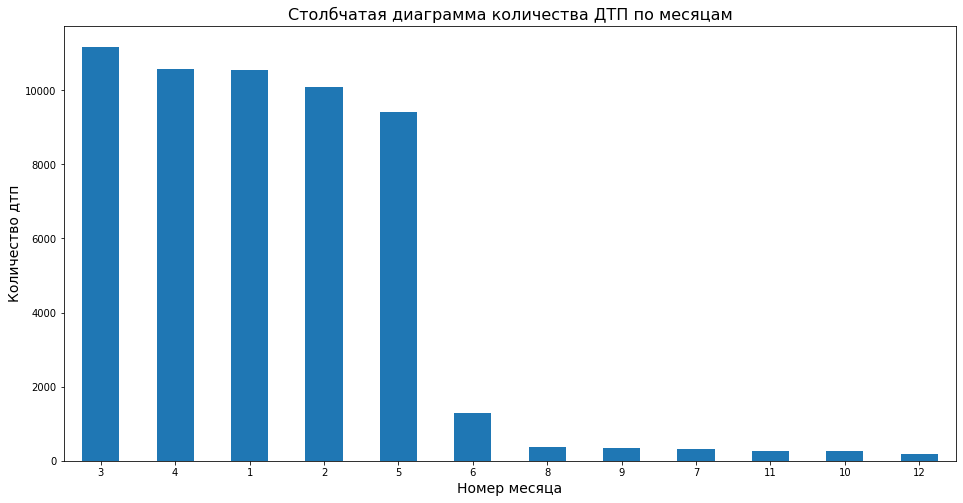

In [30]:
fig, ax = plt.subplots()
ax = df['collision_date'].value_counts().plot.bar()

plt.xlabel('Номер месяца', fontsize = 14)
plt.ylabel('Количество дтп', fontsize = 14)
plt.title('Столбчатая диаграмма количества ДТП по месяцам', fontsize = 16)
plt.xticks(rotation='horizontal')
plt.show()

#### Сумма страховки

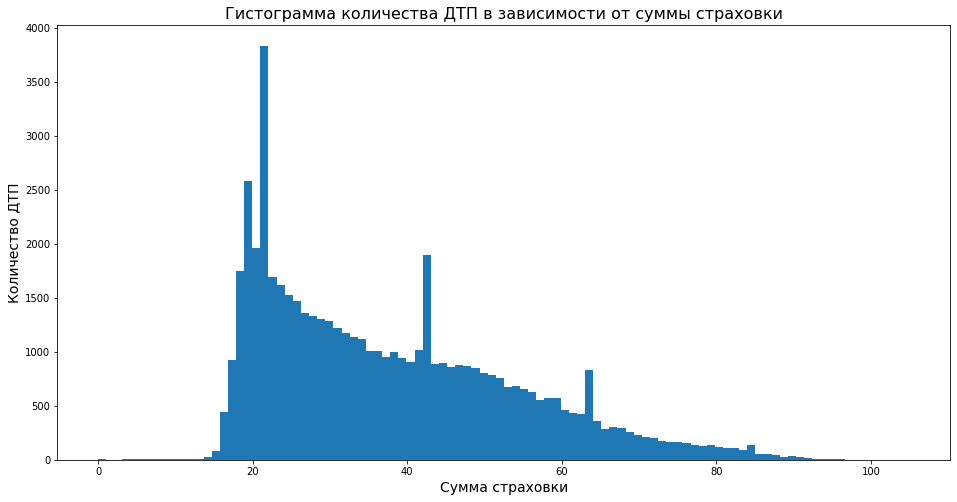

In [31]:
plt.figure(figsize=(16,8))
plt.hist(df['insurance_premium'], bins = 100)
plt.ylabel('Количество ДТП', fontsize = 14)
plt.xlabel('Сумма страховки', fontsize = 14)
plt.title('Гистограмма количества ДТП в зависимости от суммы страховки', fontsize = 16)
plt.show()

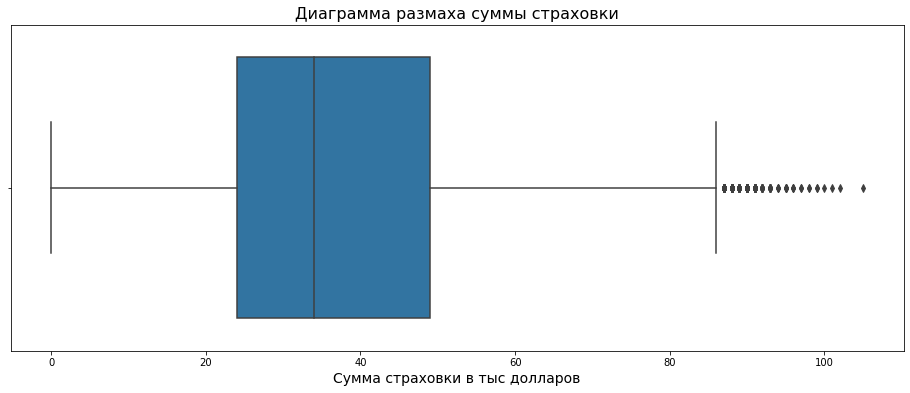

In [32]:
plt.figure(figsize=(16, 6))
boxplot = sns.boxplot(x = df["insurance_premium"])
boxplot.axes.set_title("Диаграмма размаха суммы страховки", fontsize=16)
boxplot.set_xlabel("Сумма страховки в тыс долларов", fontsize=14)
plt.show()

In [33]:
# Подсчет верхней границы

q75,q25 = np.percentile(df['insurance_premium'], [75,25])
intr_qr = q75-q25

max = q75+(1.5*intr_qr)

In [34]:
max

86.5

Сумма страховки, превыщающая значение 86.5 тыс долларов является выбросами. Удалим их

In [35]:
ind_missing = df.query('vehicle_age > @max').index
df.drop(ind_missing, axis=0, inplace = True)

#### Возраст машины

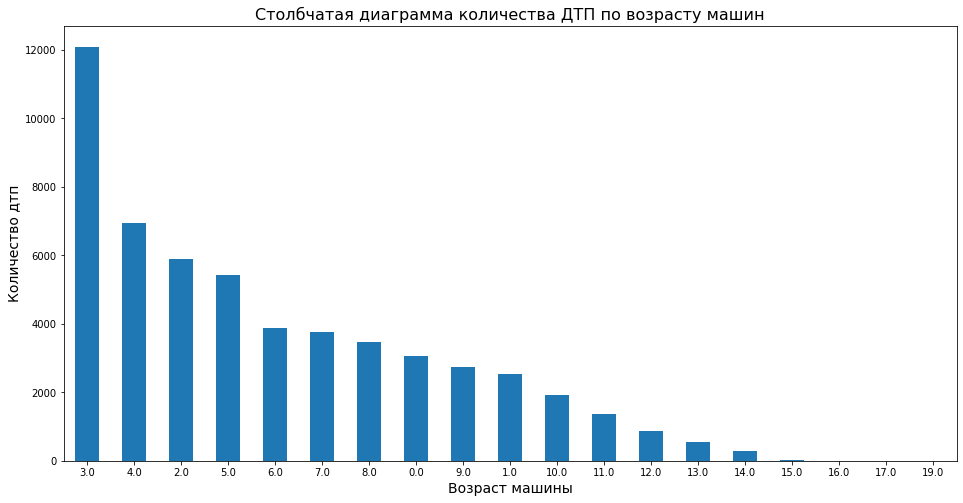

In [36]:
fig, ax = plt.subplots()
ax = df['vehicle_age'].value_counts().plot.bar()

plt.xlabel('Возраст машины', fontsize = 14)
plt.ylabel('Количество дтп', fontsize = 14)
plt.title('Столбчатая диаграмма количества ДТП по возрасту машин', fontsize = 16)
plt.xticks(rotation='horizontal')
plt.show()

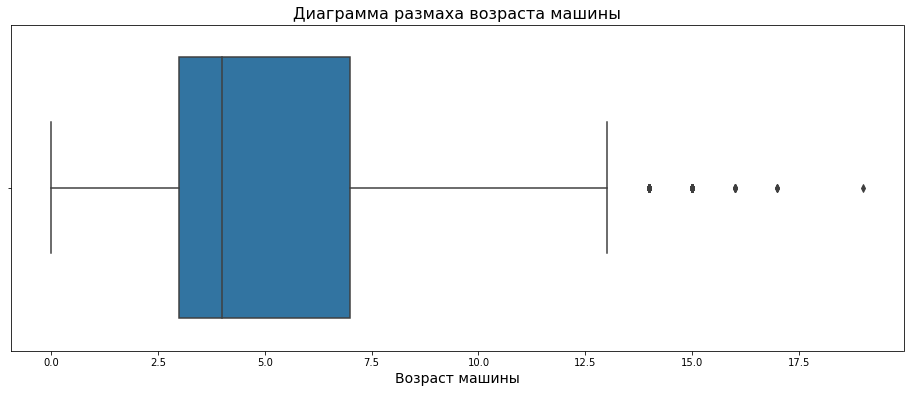

In [37]:
plt.figure(figsize=(16, 6))
boxplot = sns.boxplot(x = df["vehicle_age"])
boxplot.axes.set_title("Диаграмма размаха возраста машины", fontsize=16)
boxplot.set_xlabel("Возраст машины", fontsize=14)
plt.show()

In [38]:
# Подсчет верхней границы

q75,q25 = np.percentile(df['vehicle_age'], [75,25])
intr_qr = q75-q25

max = q75+(1.5*intr_qr)

In [39]:
max

13.0

In [40]:
df.query('vehicle_age > @max')

,party_sobriety,cellphone_in_use,vehicle_age,weather_1,road_surface,lighting,county_location,insurance_premium,collision_date,at_fault
148,had not been drinking,0.0,14.0,clear,dry,daylight,san bernardino,81.0,2,0
281,had not been drinking,0.0,14.0,clear,dry,daylight,solano,57.0,3,0
405,had not been drinking,0.0,14.0,clear,dry,daylight,sacramento,64.0,3,1
591,had not been drinking,0.0,14.0,clear,dry,dark with street lights,orange,53.0,11,0
1021,had not been drinking,0.0,16.0,clear,dry,daylight,san bernardino,77.0,3,0
...,...,...,...,...,...,...,...,...,...,...
55679,had not been drinking,0.0,14.0,clear,dry,daylight,los angeles,88.0,4,1
55799,had not been drinking,0.0,14.0,clear,dry,daylight,orange,91.0,5,1
55851,had not been drinking,0.0,14.0,clear,dry,daylight,ventura,90.0,1,0
55913,had not been drinking,0.0,14.0,clear,dry,daylight,los angeles,91.0,2,1


Возраст машины более 13 лет - выбросы, удалим их

In [41]:
ind_missing = df.query('vehicle_age > @max').index
df.drop(ind_missing, axis=0, inplace = True)

#### Трезвость участника

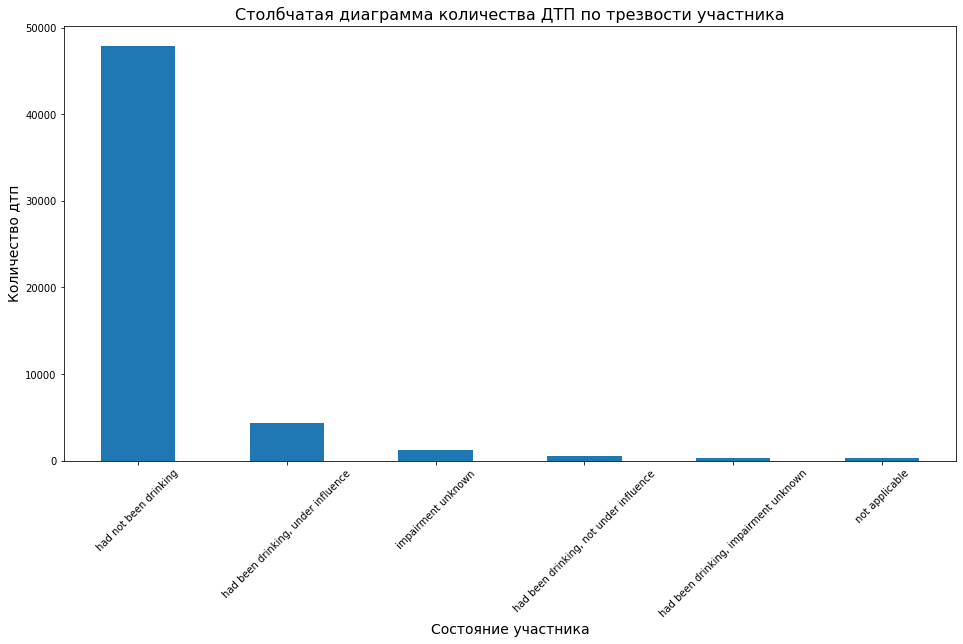

In [42]:
fig, ax = plt.subplots()
ax = df['party_sobriety'].value_counts().plot.bar()

plt.xlabel('Состояние участника', fontsize = 14)
plt.ylabel('Количество дтп', fontsize = 14)
plt.title('Столбчатая диаграмма количества ДТП по трезвости участника', fontsize = 16)
plt.xticks(rotation=45)
plt.show()

Подавляющее большинство водителей были трезвы на момент возникновения ДТП

In [43]:
df['party_sobriety'].value_counts(normalize=True)

had not been drinking                     0.877121
had been drinking, under influence        0.080684
impairment unknown                        0.022400
had been drinking, not under influence    0.010494
had been drinking, impairment unknown     0.004715
not applicable                            0.004586
Name: party_sobriety, dtype: float64

87% водителей были трезвы, это конечно много, но все же от данной переменной избавляться не будем

#### Наличие телефона в автомобиле

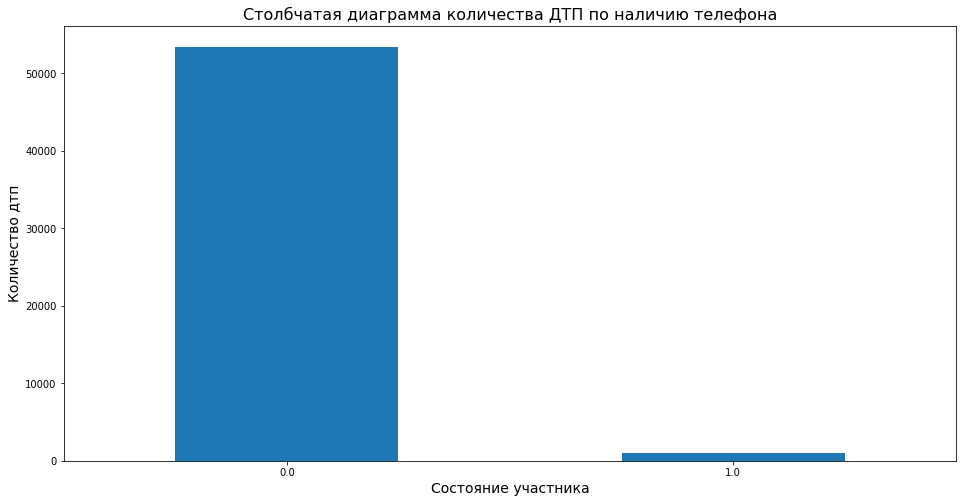

In [44]:
fig, ax = plt.subplots()
ax = df['cellphone_in_use'].value_counts().plot.bar()

fig.set_figwidth(16)
fig.set_figheight(8)

plt.xlabel('Состояние участника', fontsize = 14)
plt.ylabel('Количество дтп', fontsize = 14)
plt.title('Столбчатая диаграмма количества ДТП по наличию телефона', fontsize = 16)
plt.xticks(rotation='horizontal')
plt.show()

In [45]:
df['cellphone_in_use'].value_counts(normalize=True)

0.0    0.980719
1.0    0.019281
Name: cellphone_in_use, dtype: float64

98% водителей не имели возможности ведения разговора по громкой связи. А вот этот признак уже наверняка не является информативным. Удалим его

In [46]:
df.drop(['cellphone_in_use'], axis= 1, inplace=True)

#### Погода

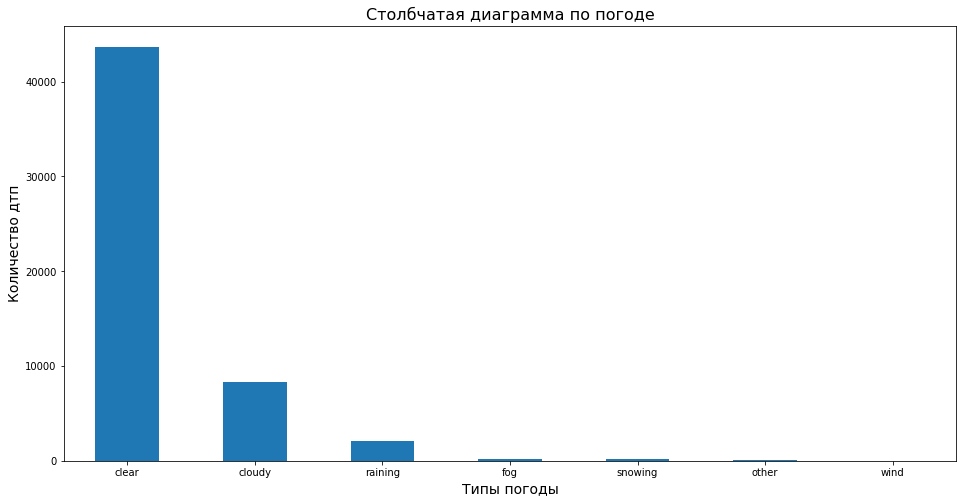

In [47]:
fig, ax = plt.subplots()
ax = df['weather_1'].value_counts().plot.bar()

plt.xlabel('Типы погоды', fontsize = 14)
plt.ylabel('Количество дтп', fontsize = 14)
plt.title('Столбчатая диаграмма по погоде', fontsize = 16)
plt.xticks(rotation='horizontal')
plt.show()

Большую часть происшествий зафиксировали в ясную погоду

#### Состояние дороги

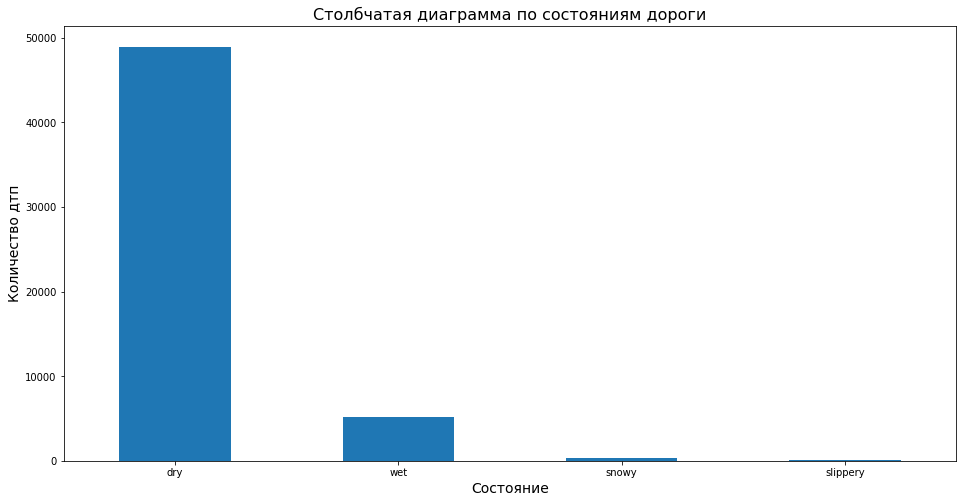

In [48]:
fig, ax = plt.subplots()
ax = df['road_surface'].value_counts().plot.bar()

plt.xlabel('Состояние', fontsize = 14)
plt.ylabel('Количество дтп', fontsize = 14)
plt.title('Столбчатая диаграмма по состояниям дороги', fontsize = 16)
plt.xticks(rotation='horizontal')
plt.show()

In [49]:
df['road_surface'].value_counts(normalize=True)

dry         0.897797
wet         0.094865
snowy       0.006549
slippery    0.000789
Name: road_surface, dtype: float64

Возможно этот признак тоже следовало бы удалить, но пока что оставим его

#### Освещение

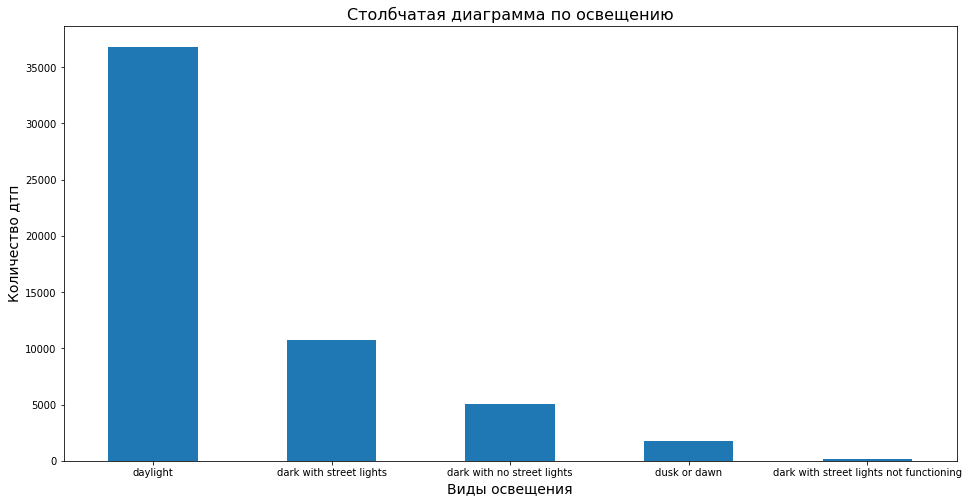

In [50]:
fig, ax = plt.subplots()
ax = df['lighting'].value_counts().plot.bar()

plt.xlabel('Виды освещения', fontsize = 14)
plt.ylabel('Количество дтп', fontsize = 14)
plt.title('Столбчатая диаграмма по освещению', fontsize = 16)
plt.xticks(rotation='horizontal')
plt.show()

Больше половины дтп произошли при дневном свете

#### Название географического региона

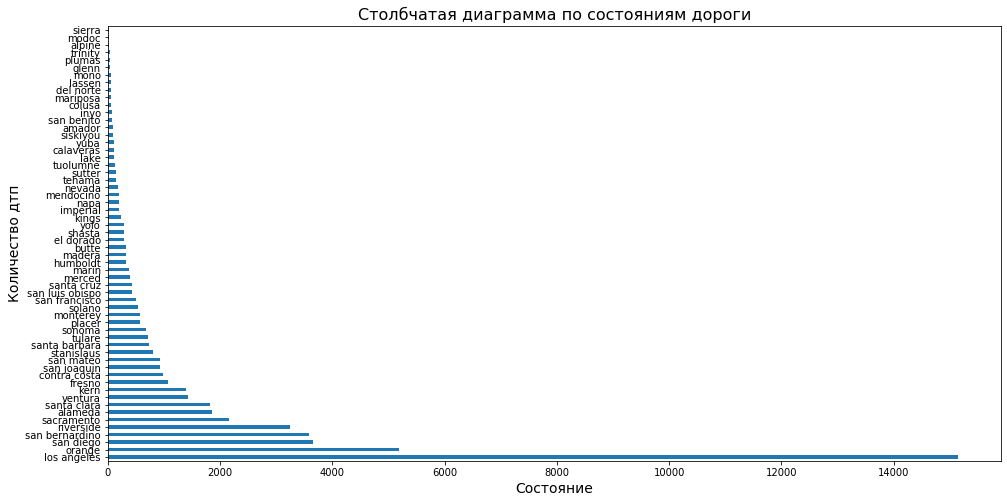

In [51]:
fig, ax = plt.subplots()
ax = df['county_location'].value_counts().plot.barh()

plt.xlabel('Состояние', fontsize = 14)
plt.ylabel('Количество дтп', fontsize = 14)
plt.title('Столбчатая диаграмма по состояниям дороги', fontsize = 16)
plt.xticks(rotation='horizontal')
plt.show()

Если рассматривать количество дтп по городам, то тут заметно, что большая часть происшествий произошла в самом крупном городе из штата Калифорния - Лос-Анджелесе. 

#### Дубликаты, которые могли возникнуть после преобразования данных

In [52]:
df.duplicated().sum()

11184

In [53]:
df = df.drop_duplicates()

In [54]:
df.shape

(43325, 9)

#### Вывод

В отобранных данных было много пропусков, выбросов и дубликатов. От всего этого избавились, можно идти дальше

Большая часть признаков - это названия городов, удалим данный признак для ускорения обучения моделей

In [55]:
df.drop(['county_location'], axis= 1, inplace=True)

### Подготовка выборок и масштабирование данных

In [56]:
x = df.drop(columns=['at_fault'])
y = df['at_fault']

x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.3,
    random_state = 67)

scaler = StandardScaler()
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value= -1)
ohe_enc = OneHotEncoder(handle_unknown='ignore', drop='first')

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
num_cols.remove('at_fault')
cat_cols = df.select_dtypes(include=['object']).columns.to_list()

# Создание преобразованных строк ohe
cols_train_ohe = ohe_enc.fit_transform(x_train[cat_cols])
cols_train_ohe = pd.DataFrame(cols_train_ohe.todense(), columns=ohe_enc.get_feature_names())

cols_test_ohe = ohe_enc.transform(x_test[cat_cols])
cols_test_ohe = pd.DataFrame(cols_test_ohe.todense(), columns=ohe_enc.get_feature_names())

# Объединение с числовыми признаками
x_train_ohe = x_train[num_cols].reset_index(drop=True).join(cols_train_ohe)
x_test_ohe = x_test[num_cols].reset_index(drop=True).join(cols_test_ohe)

# Создание выборок с порядковым кодированием
x_train_ord = pd.DataFrame(ord_enc.fit_transform(x_train), columns=x_train.columns)
x_test_ord = pd.DataFrame(ord_enc.transform(x_test), columns=x_test.columns)

# Масштабирование
x_train_ohe[num_cols] = scaler.fit_transform(x_train_ohe[num_cols])
x_test_ohe[num_cols] = scaler.transform(x_test_ohe[num_cols])

x_train_ord[num_cols] = scaler.fit_transform(x_train_ord[num_cols])
x_test_ord[num_cols] = scaler.transform(x_test_ord[num_cols])


In [57]:
x_train_ohe.shape

(30327, 21)

In [58]:
x_test_ohe.shape

(12998, 21)

In [59]:
x_train_ord.shape

(30327, 7)

In [60]:
x_test_ord.shape

(12998, 7)

### Исследование баланса классов

In [61]:
df['at_fault'].value_counts(normalize=True)

1    0.513029
0    0.486971
Name: at_fault, dtype: float64

51% виновных и 49% невиновных - классы сбалансированны

## Построение моделей

Поскольку наши классы сбалансированны, в качестве оптимизационной метрики можно взять `accuracy`. Помимо нее посчитаем `f1` и `auc-roc`

### Логистическая регрессия

In [62]:
model_lr = LogisticRegression()
cv_lr = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=67)

# Пространство поиска
space = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
         'penalty': ['none', 'l1', 'l2', 'elasticnet'],
         'C': loguniform(1e-5, 100)
    
}

search = RandomizedSearchCV(model_lr, space, n_iter=5, scoring='accuracy', n_jobs=-1, cv=cv_lr, random_state=67)

result = search.fit(x_train_ohe, y_train)

In [63]:
print('Лучшие гиперпараметры: %s' % result.best_params_)

Лучшие гиперпараметры: {'C': 0.6327732420620185, 'penalty': 'l1', 'solver': 'liblinear'}


In [64]:
# Кросс-валидация 

model_lr = result.best_estimator_
scores_lr = cross_validate(model_lr, x_train_ohe, y_train, cv=5, scoring=('accuracy', 'f1', 'roc_auc'))
scores_lr

{'fit_time': array([0.86325407, 0.87373614, 0.84128213, 0.94576001, 0.78553987]),
 'score_time': array([0.01239181, 0.01148486, 0.01844573, 0.01143909, 0.01110697]),
 'test_accuracy': array([0.62677217, 0.62050775, 0.60230833, 0.62539159, 0.62308326]),
 'test_f1': array([0.56072953, 0.55662558, 0.52853792, 0.54541817, 0.54786392]),
 'test_roc_auc': array([0.6594718 , 0.65892055, 0.63990713, 0.66204407, 0.66516164])}

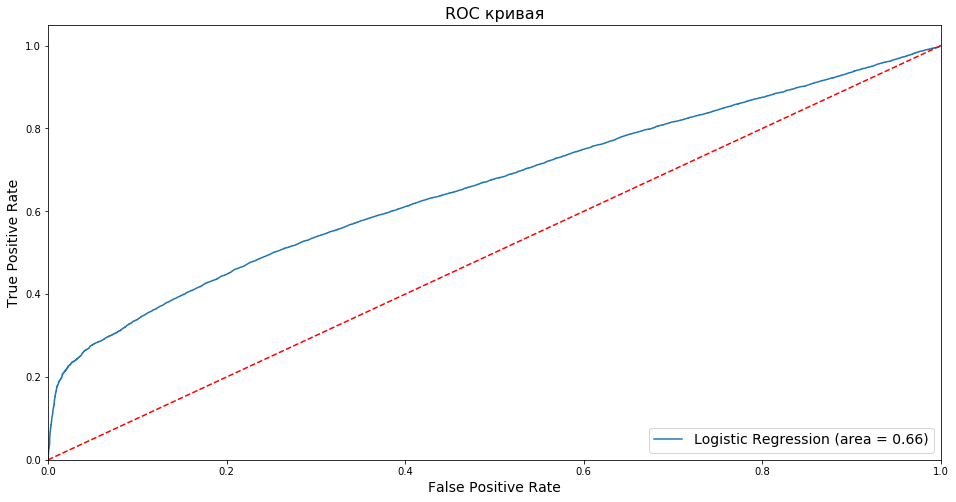

In [65]:
# Построение ROC кривой
fpr, tpr, thresholds = roc_curve(y_train, model_lr.predict_proba(x_train_ohe)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % scores_lr['test_roc_auc'].mean())
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC кривая', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

### Модель случайного леса

In [66]:
model_rf = RandomForestClassifier()

cv_rf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=67)

# Пространство поиска
space = {'bootstrap': [True, False],
         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
         'max_features': ['log2', 'sqrt', None],
         'min_samples_leaf': [1, 2, 4],
         'min_samples_split': [2, 5, 10],
         'n_estimators': [100, 150, 200]}

search = RandomizedSearchCV(model_rf, space, n_iter=5, scoring='accuracy', n_jobs=-1, cv=cv_rf, random_state=67)

result = search.fit(x_train_ord, y_train)

In [67]:
print('Лучшие гиперпараметры: %s' % result.best_params_)

Лучшие гиперпараметры: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}


In [68]:
# Кросс-валидация

model_rf = result.best_estimator_
scores_rf = cross_validate(model_rf, x_train_ord, y_train, cv=5, scoring=('accuracy', 'f1', 'roc_auc'))
scores_rf

{'fit_time': array([1.24819684, 1.18720102, 1.16676307, 1.6274538 , 1.86756921]),
 'score_time': array([0.19327807, 0.18389511, 0.1779933 , 0.1924932 , 0.20647287]),
 'test_accuracy': array([0.63386086, 0.63287174, 0.62061006, 0.63165705, 0.6370981 ]),
 'test_f1': array([0.57476546, 0.57540515, 0.55741489, 0.57021932, 0.57972121]),
 'test_roc_auc': array([0.68211556, 0.67969649, 0.66737868, 0.68321313, 0.68036194])}

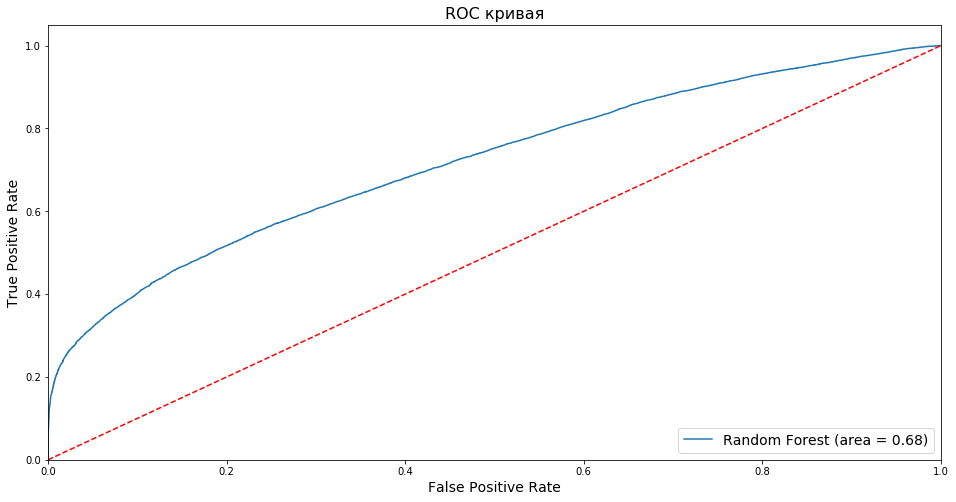

In [69]:
# Построение ROC кривой
fpr, tpr, thresholds = roc_curve(y_train, model_rf.predict_proba(x_train_ord)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % scores_rf['test_roc_auc'].mean())
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC кривая', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

### Бустинговая модель

In [ ]:
model = CatBoostClassifier(loss_function='Logloss', cat_features=cat_cols)

grid = {'iterations': [100, 200, 300, 400, 500, 800, 1000],
        'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9],
        'depth': [2, 4, 6, 8, 10]}

grid_search_result = model.randomized_search(grid,
                                       X=x_train,
                                       y=y_train,
                                       cv=2,
                                       verbose = False)
                                       #plot=False)


In [ ]:
# Обучение модели с лучшими гиперпараметрами 

best_params = grid_search_result['params']
model_cb = CatBoostClassifier(loss_function='Logloss',
                              depth=best_params['depth'],
                              iterations=best_params['iterations'],
                              learning_rate=best_params['learning_rate'],
                              )

model_cb.fit(x_train, y_train, eval_set=(x_test,y_test), cat_features=cat_cols, verbose=False)

In [ ]:
# Кросс-валидация катбуст

params = {
    'loss_function': 'Logloss',
    'iterations': best_params['iterations'],
    'custom_loss': ['AUC', 'F1', 'Accuracy'],
    'random_seed': 67,
    'learning_rate': best_params['learning_rate'],
    'depth': best_params['depth']
}

cv_data = cv(
    params=params,
    pool=Pool(x_train, label=y_train, cat_features=cat_cols),
    fold_count=5,
    shuffle=True, 
    partition_random_seed=67,
    plot=True, 
    stratified=True, 
    verbose=False
)

In [ ]:
# Построение ROC кривой
fpr, tpr, thresholds = roc_curve(y_train, model_cb.predict_proba(x_train)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='CatBoost (area = %0.2f)' % cv_data['test-AUC-mean'].mean())
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC кривая', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

### Сравнительная таблица

In [ ]:
table = {"Модель логистической регрессии": pd.Series([scores_lr['test_f1'].mean(), scores_lr['test_accuracy'].mean(), scores_lr['test_roc_auc'].mean()] , index=['F1', 'Accuracy', 'Roc-Auc']),
        'Модель случайного леса': pd.Series([scores_rf['test_f1'].mean(), scores_rf['test_accuracy'].mean(), scores_rf['test_roc_auc'].mean()], index=['F1', 'Accuracy', 'Roc-Auc']),
        'Модель бустинга': pd.Series([cv_data['test-F1-mean'].mean(), cv_data['test-Accuracy-mean'].mean(), cv_data['test-AUC-mean'].mean()], index=['F1', 'Accuracy', 'Roc-Auc'])}
table = pd.DataFrame(table)
table

### Вывод

Модель бустинга выигрывает по всем матрикам качества у других моделей.

Модель логистической регрессии оказалась слабее остальных моделей. 

В общем и целом, данные модели, конечно, лучше чем dummy модель будут предсказывать вероятность вины в ДТП, но все же назвать приемлемой в практических целях, на мой взгляд, ни одну из них нельзя.

**Лучшей моделью из созданных, является бустинговая модель**

## Проверка лучшей модели

In [ ]:
# Проверка метрик лучшей модели на тесте

preds = model_cb.predict(x_test)
f1_cb = f1_score(y_test, preds)
accuracy_cb = accuracy_score(y_test, preds)
cb_roc_auc = roc_auc_score(y_test, model_cb.predict_proba(x_test)[:, 1])
print(f'F1 на тесте: {f1_cb}')
print(f'Accuracy на тесте: {accuracy_cb}')
print(f'Roc_Auc на тесте: {cb_roc_auc}')

### Матрица ошибок

In [ ]:
plot_confusion_matrix(model_cb, x_test, y_test)  
plt.show()

In [ ]:
print(f'Полнота: {recall_score(y_test, preds)}')
print(f'Точность: {precision_score(y_test, preds)}')

In [ ]:
# Построение ROC кривой
fpr, tpr, thresholds = roc_curve(y_test, model_cb.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % cb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC кривая', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.show()

### Анализ важности факторов

In [ ]:
# Вывод топ-5 важных фичей на основе построенной модели

importances = model_cb.feature_importances_

feature_list = list(x_train.columns)

feature_results = pd.DataFrame({'Признак': feature_list,'Важность': importances})

feature_results = feature_results.sort_values('Важность',ascending = False).reset_index(drop=True)

feature_results[:5]

Наиболее важные признаки (в порядке убывания важности):

- Трезвость участника
- Сумма страховки
- Освещение
- Возраст авто
- Дорожное покрытие

### Графики зависимости значимых факторов и целевой переменной

#### Сумма страховки и виновности

In [ ]:
sns.scatterplot(x=df.index, y=df['insurance_premium'], hue = df['at_fault'])
plt.ylabel('Сумма страховки', fontsize=14)
plt.title('Точечный график зависимости виновности и суммы страховки', fontsize=16)
plt.show()

Каких-то однозначных выводов по нему сделать не получится. Попробуем посчитать среднюю сумму страховки для каждого класса

In [ ]:
df.groupby('at_fault')['insurance_premium'].mean().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.xlabel('Метки классов', fontsize=14)
plt.ylabel('Средняя сумма страховки', fontsize=14)
plt.title('Столбчатая диаграмма средних значений суммы страховки для каждого класса', fontsize=16)
plt.show()

Средняя сумма страховки у виновных в происшествии немного ниже, похоже модель считает, что чем выше сумма страховки, тем ниже вероятность быть виновным в ДТП. В общем, это логично, поскольку для снижения суммы страховки нужна аккуратная езда (без аварий)

#### Уровень трезвости водителя и виновность

In [ ]:
sns.histplot(data=df, x="party_sobriety", binwidth=0.1, hue="at_fault")
plt.xticks(rotation=45)
plt.title('Столбчатая диаграмма количества виновных/невиновных в зависимости от уровня трезвости', fontsize=16)
plt.xlabel('Уровень трезвости', fontsize=14)
plt.ylabel('Количество ДТП', fontsize=16)
plt.show()

Среди не пивших водителей больше невиновных (на несколько тысяч), при этом среди тех, кто был пьян, под влиянием - практически все виновны в ДТП. В целом похоже на правду

Для учета этого фактора необходимо внедрить в каршеринговые автомобили обязательное прохождение алкотестера

## Вывод

Лучшей моделью была выявлена **бустинговая модель Catboost**. Получившиеся метрики качества модели:
- **F1** - 0.57
- **Accuracy** - 0.63
- **Roc-Auc** - 0.68
- **Recall** - 0.49
- **Precision** - 0.69

Наиболее важными факторами, на основе модели были выделены `трезвость участника` (в нетрезвом виде гораздо больше было виновных чем невиновных) и `сумма страховки`. Чем она выше, тем ниже вероятность виновности водителя, поскольку сумма страховки зависит от различных факторов, таких как стаж вождения, возраст водителя, наличие/отсутствие аварий за год и др., то можно предположить, что водители с высокой суммой страховки стараются быть более аккуратными на дороге. Из этого вытекает вывод о правильно выявленной закономерности со стороны модели.

Конечно в данном виде модель нельзя назвать удовлетворительной, с задачей классификации риска для водителя стать виновник дтп она справляется лучше случайной модели, но все еще недостаточно хорошо. 

На мой взгляд, систему можно улучшить если собрать дополнительную информацию о водителях, к примеру:
- Водительский стаж
- Возраст водителя
- Семейное положение
- Необходимо дополнить признак состояния участника: (физическое или с учётом принятых лекарств) сейчас слишком много пропусков
- Возможно информация об уровне пробок по выбранному маршруту тоже может быть полезной